# Image Classification using BigTransfer (BiT)
### 用BiT实现图像分类

原文链接：https://keras.io/examples/vision/bit/

## Note:
BiT是谷歌在2020年提出的一种迁移学习模型，其实可以认为是“大力出奇迹”，他们花费了大量的钞票将模型在GPU上训练，数据集也是十余倍ImageNet数据集，我们直接使用就行，给模型很少量的自己数据就可以达到非常高的性能，因为这个模型已经从非常大的数据集上学习到了很多的特征。他允许自己的数据集每个类别的最少样本量为1，这为少样本学习提供了很大的帮助。  

提供了 [TF2, Jax, Pytorch](https://github.com/google-research/big_transfer)三种复现代码，同时在 [TensorFlow Hub](https://tfhub.dev/google/collections/bit/1) 提供了训练好的模型。  

TensorFlow Hub 是一个非常好的平台，里面有大量已经训练好的模型可以直接拿来使用，这个案例可以当作 TensorFlow Hub的一个简单使用教程。  

还有一点需要说明下，这篇原始博客写的比较粗糙给后面的阅读带来了一定难度，特别是在其超参数的设置上。但博客所使用的BiT效果还是非常明显的，能在极短的时间内完成训练并达到一个很高的准确率。

------------

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

--------

## Gather Flower Dataset

In [2]:
train_ds, validation_ds = tfds.load(
    "tf_flowers", split=["train[:85%]", "train[85%:]"], as_supervised=True,
)

----------

## Visualise the dataset

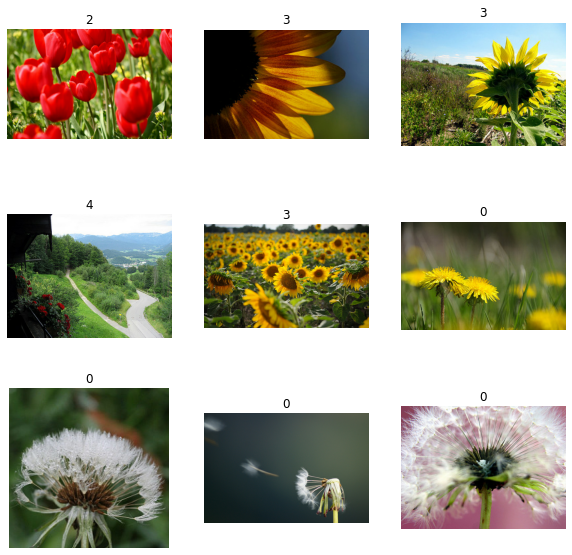

In [3]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

----------

## Define hyperparameters

此处有一个概念叫 “schedule”，通常指的是学习率衰减表或者叫学习率时间表，在TensorFlow和Keras中可以直接使用 [tf.keras.optimizers.schedules](https://keras.io/api/optimizers/learning_rate_schedules/) 类来对模型学习率进行安排（这个要比pytorch方便太多了，基本是一行代码的事），他的操作单元是step。即模型每接受 N 个step就调整一次学习率。  

这里有几个概念容易混淆：
* batch_size：单次迭代送入的样本量
* step：遍历完一个batch_size
* epoch：完整遍历一次数据集

因为显存和内存的限制，不会将全部的数据集送入模型中，所以框架是按照 batch_size 大小分批送入的，而每一批被称为一个 step，同时模型更新权重的单位默认也是 step。把所有 step 遍历完一次就等价于完成一个 epoch。  

假设一个数据集共有500个样本，设定 batch_size=20，那么对应得到的 step=500/20=25；期望模型对这个数据集训练6次，那么epochs=6。综上所述，超参数中的 batch_size 和 epoch 是没有直接对应关系的，同时这两个参数也是人为指定的，而 step 是根据 batch_size 推算出来的。

In [4]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10                 # 每个epochs需要的step次数
AUTO = tf.data.AUTOTUNE              # 自动并行优化
NUM_CLASSES = 5 
SCHEDULE_LENGTH = (500)
SCHEDULE_BOUNDARIES = [200,300,400]  # 衰减边界，0-200是一个学习率；201-300是一个学习率...

这里有个问题，就是此处既指定了 batch_size，也指定了 steps_per_epoch，不是说 step 值是根据 batch_size 推算出来的么？  

如果你仔细观察会发现这里没有指定 epochs 值，他在此处处理的确实不好，很多超参数值都是跟着 SCHEDULE_LENGTH 的值变化的，包括 epochs，甚至 SCHEDULE_LENGTH 这个值自身都发生了变化，这极大降低了代码代码的可读性。

根据 Keras 官方文档对 [fit()](https://keras.io/api/models/model_training_apis/) 函数参数的介绍可以知道以下几点：
* batch_size 值可以不指定，同时如果输入的是 tf.dataset.Dataset 类型的数据那么指定了也无效；
* epochs 值当 steps_per_epoch 值为非None的时候该值表示为一个游标，说明一次epoch的量并不是完整的数据集，而是 batch_size * steps_per_epoch。

而博主在后面 model.fit() 的时候又写入了 batch_size 这个参数，此时指定该参数并不会起到作用。  

我并不清楚为什么博主要这样设置超参数，这可能是和BiT的原文有关，但这里仍然按照他的意思继续下去。如果你们以后要写这类代码，同时一些参数是非常规的，那么最好写上注释。

--------

## Define preprocessing helper functions

这里就用到了 TensorFlow V2.0 的很多特性，特别是 [tf.image](https://tensorflow.google.cn/api_docs/python/tf/image) 的包，可以省去造轮子的操作。  

在之前的博客 [Barlow Twins for Contrastive SSL]('../BarlowTwinsForContrastiveSSL.ipynb') 中提到了博主写了很多类来实现数据增强，里面的所有操作都可以使用现成的包实现，感兴趣的可以仿照下面的代码其进行修改。

In [5]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)

In [6]:
@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = image / 255.0
    return (image, label)

In [7]:
DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # 保证在一个epochs中每个样本至少能被训练50次。

----------

## Define the data pipeline

In [8]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(repeat_count)  # 重复次数 = dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

-------

## Visualise the training samples

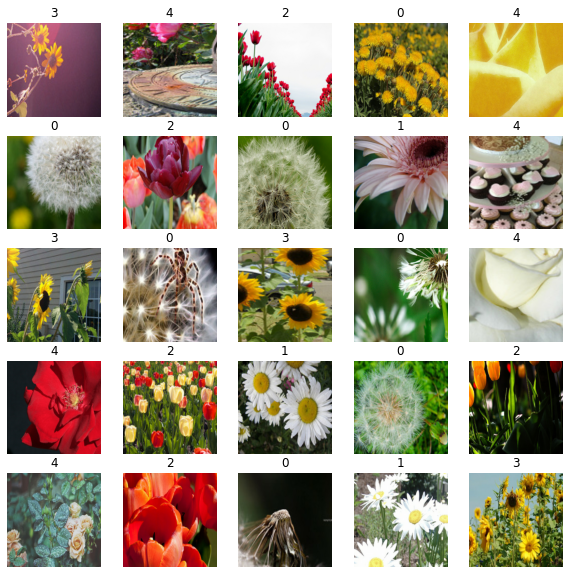

In [9]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

-----------

## Load pretrained TF-Hub model into a KerasLayer

In [10]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

---------

## Create BigTransfer (BiT) model

为了完成迁移学习，这里做了以下两步：  
1. 提出BiT的输出层，保留了“pre-logits”的输出（只保留了特征，不要决策层，这也是迁移学习中非常常见的作法）。
2. 添加了一个新的输出层，层的神经元个数等于我们数据集的列别数。

In [11]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)

In [12]:
model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

------------

## Define optimizer and loss

初始学习率

In [13]:
learning_rate = 0.003 * BATCH_SIZE / 512  # 
learning_rate

0.000375

In [14]:
learning_rate

0.000375

In [15]:
# 根据 SCHEDULE_BOUNDARIES 设定的边界，每次学习率衰减都 /10
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)

按照上面的学习率衰减表可以得到学习率的分布如下所示：  
|steps|learning rate|
|---|---|
|0-200|0.000375|
|201-300|0.0000375|
|301-400|0.00000375|
|>401|0.00000375|  

In [16]:
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

----------

## Compile the model

In [17]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

---------

## Set up callbacks

设置提前结束的回调函数，监控值为验证集准确率。
* monitor: 需要监控的参数；
* patience: N 次训练后被监控的参数没有得到改善则停止；
* restore_best_weights： 保存最佳的权重。

此处由于没有设置保存的回调函数，所以参数 restore_best_weights 也没有起到任何作用。

In [18]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

-----------

## Train the model

这里其实就是前文中提到博主没有处理好的地方，按照官方文档中的提示，此处的batch_size参数并没有生效，因为传入的是 tf.data.Dataset 类型的数据。该类型的数据通过 **.batch()** 进行 batch_size 的设置。

In [19]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/400
10/10 [==============================] - 36s 2s/step - loss: 0.7472 - accuracy: 0.7859 - val_loss: 0.1853 - val_accuracy: 0.9564
Epoch 2/400
10/10 [==============================] - 12s 1s/step - loss: 0.1401 - accuracy: 0.9594 - val_loss: 0.1099 - val_accuracy: 0.9691
Epoch 3/400
10/10 [==============================] - 12s 1s/step - loss: 0.1693 - accuracy: 0.9406 - val_loss: 0.0867 - val_accuracy: 0.9709
Epoch 4/400
10/10 [==============================] - 12s 1s/step - loss: 0.1255 - accuracy: 0.9531 - val_loss: 0.0858 - val_accuracy: 0.9709
Epoch 5/400
10/10 [==============================] - 12s 1s/step - loss: 0.1486 - accuracy: 0.9438 - val_loss: 0.0795 - val_accuracy: 0.9727
Epoch 6/400
10/10 [==============================] - 12s 1s/step - loss: 0.1232 - accuracy: 0.9516 - val_loss: 0.0748 - val_accuracy: 0.9800
Epoch 7/400
10/10 [==============================] - 12s 1s/step - loss: 0.1258 - accuracy: 0.9500 - val_loss: 0.0824 - val_accuracy: 0.9727
Epoch 8/400
1

--------

## Plot the training and validation metrics

In [20]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()

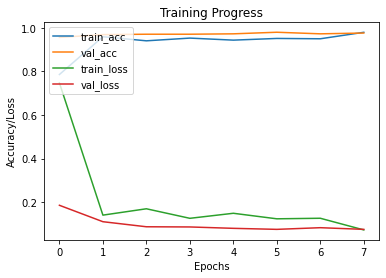

In [21]:
plot_hist(history)

-------

## Evaluate the model

In [22]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

9/9 [==============================] - 8s 885ms/step - loss: 0.0748 - accuracy: 0.9800
Accuracy: 98.00%
